In [13]:
%matplotlib inline

In [14]:
import os
path = os.path.abspath(os.getcwd())

In [15]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
import time
import csv

from scipy.optimize import curve_fit

from nistrng import check_eligibility_all_battery, run_all_battery, SP800_22R1A_BATTERY#, pack_sequence
from nistrng.sp800_22r1a import MonobitTest, FrequencyWithinBlockTest, RunsTest, LongestRunOnesInABlockTest, \
    DiscreteFourierTransformTest, NonOverlappingTemplateMatchingTest, SerialTest, ApproximateEntropyTest, \
    CumulativeSumsTest, RandomExcursionTest, RandomExcursionVariantTest

In [16]:
pd.set_option('display.max_rows', 100)
pd.set_option("display.max_colwidth",100)

In [17]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('ggplot')

In [ ]:
# Set the default size of various textual elements
plt.rcParams['text.usetex'] = False  # Enable LaTeX rendering
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'

a, b, c = 18, 20, 24
plt.rcParams['font.size'] = b            # sets the default font size
plt.rcParams['axes.labelsize'] = c       # for x and y labels

plt.rcParams['axes.titlesize'] = c       # for subplot titles
plt.rcParams['xtick.labelsize'] = a      # for x-axis tick labels
plt.rcParams['ytick.labelsize'] = a      # for y-axis tick labels
plt.rcParams['legend.fontsize'] = b      # for legend text

plt.rcParams['axes.labelpad'] = 15

In [42]:
# OPTIONS
bitsize: np.uint64 = 32
mask: np.uint64 = np.uint64(2**bitsize - 1)

np.random.seed()
rd.seed()

In [20]:
def printif(verbose, string):
    if verbose:
        print(string)

In [ ]:
def write_to_csv(filename, data):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)
       

def append_to_csv(filename, data):
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

# I/ Preliminaries

In [ ]:
def printif(verbose, string):
    if verbose:
        print(string)

In [ ]:
def write_to_csv(filename, data):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)
       

def append_to_csv(filename, data):
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

## 1) Binary operations

In [ ]:
def xor(a, b):
    return (np.uint64(a) ^ np.uint64(b)) & mask

In [ ]:
def add(a, b):

    with np.errstate(over='ignore'):  # suppresses overflow warnings
        result = np.uint64(a) + np.uint64(b)
    return result & mask

In [ ]:
def bitrol(n, r):
    return ((np.uint64(n) << np.uint64(r)) & mask) | ((np.uint64(n) >> np.uint64(bitsize - r)) & mask)

In [ ]:
def swab(value):
    if value < 0 or value > 0xFFFF:
        raise ValueError("Value must be a 16-bit unsigned integer")

    return np.uint64((value & np.uint64(0xFF)) << np.uint64(8)) | ((value & np.uint64(0xFF00)) >> np.uint64(8))

In [ ]:
def binprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]:

        s += bin(i) + ", "
    s += bin(pool[-1]) + "]"
    print(s)

In [ ]:
def strprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]:

        s += str(i) + ", "
    s += str(pool[-1]) + "]"
    print(s)

In [ ]:
def pack_sequence_64(sequence: np.ndarray) -> np.ndarray:
    sequence_array = np.array(sequence, dtype=np.uint64)
    return np.unpackbits(sequence_array.view(np.uint8)).astype(np.uint8)

def pack_sequence_32(sequence: np.ndarray) -> np.ndarray:
    sequence_array = np.array(sequence, dtype=np.uint32)
    return np.unpackbits(sequence_array.view(np.uint8)).astype(np.uint8)

if bitsize == 32:
    pack_sequence = pack_sequence_32
else: #64 bit case
    pack_sequence = pack_sequence_64

## 2) Entropy gathering functions
### A. Half-SipHash

In [ ]:
def hsiphash_perm(pool):
    assert(bitsize==32)
    rol32 = bitrol
   

    a, b, c, d = pool[0], pool[1], pool[2], pool[3]
   

    a = add(a, b)
    b = rol32(b, 5)
    b = xor(b, a)
    a = rol32(a, 16)
   

    c = add(c, d)
    d = rol32(d, 8)
    d = xor(d, c)
   

    a = add(a, d)
    d = rol32(d, 7)
    d = xor(d, a)
   

    c = add(c, b)
    b = rol32(b, 13)
    b = xor(b, c)
    c = rol32(c, 16)
   

    return [a, b, c, d]

In [ ]:
def siphash_mix(pool, input1, input2):
    pool[3] = xor(pool[3], input1)
    pool = hsiphash_perm(pool)
    pool[0] = xor(pool[0], input1)
   

    pool[3] = xor(pool[3], input2)
    pool = hsiphash_perm(pool)
    pool[0] = xor(pool[0], input2)
   

    return pool

In [ ]:
hsiphash_init = [ np.uint32(0), np.uint32(0), np.uint32(0x6c796765), np.uint32(0x74656462) ]
def init_siphash_pool():

    return hsiphash_init.copy()

### B. Old Fast-Mix

In [ ]:
def fast_mix_perm(pool):
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 6)
    d = bitrol(d, 27)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 16)
    d = bitrol(d, 14)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 6)
    d = bitrol(d, 27)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 16)
    d = bitrol(d, 14)
    d = xor(d, a)
    b = xor(b, c)

    return [a, b, c, d]

In [ ]:
def fast_mix(pool, input1, input2, input3, input4):
    pool[0] ^= input1
    pool[1] ^= input2
    pool[2] ^= input3
    pool[3] ^= input4
   

    return fast_mix_perm(pool)

### C. Rotations

In [ ]:
def rot_mix(pool, input1, input2, r):

    pool = xor(pool, input1)
    pool = xor(pool, input2)
    pool = bitrol(pool, r)
   

    return pool

## 3) Distributions
### A. Timestamp value

In [ ]:
def generate_cauchy(gamma, x0, size):
    cauchy_array = np.random.standard_cauchy(size) * gamma + x0
    return cauchy_array.astype(int)

In [ ]:
gamma, x0, size = 48031, 3818, 4000000
theta_distrib = generate_cauchy(gamma, x0, size)

bins = int(np.sqrt(size))
a = 2**18
plot_range = (-a,a)

print("bins  =", bins)
print("range =", plot_range)

plt.hist(theta_distrib, bins=bins, density=True, range=plot_range)
plt.title("Histogram of Generated Cauchy Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
def draw_cauchy_params(N):

    cauchy_gamma_array = np.random.uniform(4e4, 8e4, N)
    cauchy_x0_array = np.random.uniform(3e3, 8e3, N)
    cauchy_delta_array = np.random.uniform(2e7, 9e7, N)
   

    return cauchy_gamma_array, cauchy_x0_array, cauchy_delta_array

### B.Jiffy value

In [ ]:
def init_jiffy_arrays():
    global jiffy_delta_distribution, jiffy_elements, jiffy_probabilities
   

    jiffy_delta_distribution = [
        [0, 0.419073], [1, 0.027795], [2, 0.004821],
        [3, 0.004008], [4, 0.455692], [5, 0.088511]
    ]

    jiffy_elements = [element for element, _ in jiffy_delta_distribution]
    jiffy_probabilities = [probability for _, probability in jiffy_delta_distribution]

def draw_jiffy_deltas(N):
    drawn_elements = rd.choices(jiffy_elements, jiffy_probabilities, k=N)
    return [np.uint64(i) for i in drawn_elements]

def draw_jiffy_seed():
    if bitsize == 32:
        low, high = np.uint64(1e8), np.uint64(1e9)
    else:
        low, high = np.uint64(1e8), np.uint64(8e9)
   

    return rd.randrange(low, high)

def draw_jiffy_values(N):
    seed = draw_jiffy_seed()
    drawn_deltas = draw_jiffy_deltas(N)
   

    drawn_values = []
    for delta in drawn_deltas:
        seed += delta
        drawn_values.append(seed)
       

    return [np.uint64(i) for i in drawn_values]

In [ ]:
init_jiffy_arrays()
draw_jiffy_deltas(3)

In [ ]:
draw_jiffy_values(3)

### C. Instruction Pointer value

In [ ]:
def init_ip_arrays():
    global instruction_pointer_distribution, ip_elements, ip_probabilities
   

    instruction_pointer_distribution = [
        [4112549988, 0.729635], [3995109476, 0.177747], [3709896804, 0.072718],
        [4005702796, 0.010259], [3995352108, 0.004920], [4005727176, 0.000448],
        [4246767716, 0.000396], [4123167688, 0.000297], [4112865224, 0.000261],
        [3995247160, 0.000223], [3995185056, 0.000115], [4112960576, 0.000110],
        [4112786712, 0.000072], [4113351664, 0.000070], [4123167300, 0.000070],
        [3720514504, 0.000058], [3710212040, 0.000053], [3712703804, 0.000050],
        [3995424712, 0.000050], [4113352520, 0.000048]
    ]

    ip_elements = [element for element, _ in instruction_pointer_distribution]
    ip_probabilities = [probability for _, probability in instruction_pointer_distribution]

def draw_ip_values(N):
    drawn_elements = rd.choices(ip_elements, ip_probabilities, k=N)
    return [np.uint64(i) for i in drawn_elements]

In [ ]:
init_ip_arrays()
draw_ip_values(3)

#### Simulating IP values

In [ ]:
xdata = list(range(len(instruction_pointer_distribution)))
ydata = [point[1] for point in instruction_pointer_distribution]

# Double exponential fitting
def double_exponential(x, a, b, c):
    return a * np.exp(b * x) + c

ip_params, covariance = curve_fit(double_exponential, xdata, ydata, p0=(1, -1, 1))

plt.scatter(xdata, ydata, color="red", label="Original Data")
plt.plot(xdata, [double_exponential(x, *ip_params) for x in xdata], label="Fitted Curve")
plt.legend()
plt.show()

In [ ]:
def generate_ip_probabilities(n, ip_params):
    noise = np.random.uniform(0.8, 1.2, n)
    probabilities = [double_exponential(x, *ip_params)*noise[i] for i,x in enumerate(range(n))]
   

    # Normalize the probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
   

    # Generate n data points
    low, high = int(37e8), int(43e8)
    data_points = np.random.default_rng().integers(low, high, size=n)
   

    return [[data_points[i], probabilities[i]] for i in range(n)]

In [ ]:
def generate_ip_arrays(n):
    global ip_elements, ip_probabilities
   

    generated_ip = generate_ip_probabilities(n, ip_params)
    sorted_ip = sorted(generated_ip, key=lambda x: x[1], reverse=True)
   

    ip_elements = [element for element, _ in sorted_ip]
    ip_probabilities = [probability for _, probability in sorted_ip]

In [ ]:
generate_ip_arrays(20)
draw_ip_values(3)

### D. IRQ value

In [ ]:
def init_irq_arrays():
    global irq_distribution, irq_elements, irq_probabilities
   

    irq_distribution = [
        [90, 0.563053], [76, 0.052640], [77, 0.049272],
        [10, 0.044676], [70, 0.038246], [75, 0.035131],
        [69, 0.033727], [73, 0.033374], [72, 0.029866],
        [71, 0.026564], [74, 0.024222], [67, 0.018798],
        [78, 0.017512], [68, 0.014154], [89, 0.011819]
    ]

    irq_elements = [element for element, _ in irq_distribution]
    irq_probabilities = [probability for _, probability in irq_distribution]

def draw_irq_values(N):
    drawn_elements = rd.choices(irq_elements, irq_probabilities, k=N)
    return [np.uint64(i) for i in drawn_elements]

In [ ]:
init_irq_arrays()
draw_irq_values(3)

#### Simulating IRQ values

In [ ]:
xdata = list(range(len(irq_distribution)))
ydata = [point[1] for point in irq_distribution]

# Double exponential fitting
def double_exponential(x, a, b, c):
    return a * np.exp(b * x) + c

irq_params, covariance = curve_fit(double_exponential, xdata, ydata, p0=(1, -1, 1))

plt.scatter(xdata, ydata, color="red", label="Original Data")
plt.plot(xdata, [double_exponential(x, *irq_params) for x in xdata], label="Fitted Curve")
plt.legend()
plt.show()

In [ ]:
def generate_irq_probabilities(n, irq_params):
    noise = np.random.uniform(0.8, 1.2, n)
    probabilities = [double_exponential(x, *irq_params)*noise[i] for i,x in enumerate(range(n))]
   

    # Normalize the probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
   

    # Generate n data points
    data_points = np.random.default_rng().integers(1, 100, size=n)
   

    return [[data_points[i], probabilities[i]] for i in range(n)]

In [ ]:
def generate_irq_arrays(n):
    global irq_elements, irq_probabilities
    generated_irq = generate_irq_probabilities(n, ip_params)
    sorted_irq = sorted(generated_irq, key=lambda x: x[1], reverse=True)
   

    irq_elements = [element for element, _ in sorted_irq]
    irq_probabilities = [probability for _, probability in sorted_irq]

In [ ]:
generate_irq_arrays(20)
draw_irq_values(3)

# II/ Simulation

In [ ]:
chosen_tests: dict = {
    'monobit': MonobitTest(),
    'frequency_within_block': FrequencyWithinBlockTest(),
    'runs': RunsTest(),
    'longest_run_ones_in_a_block': LongestRunOnesInABlockTest(),
#     'dft': DiscreteFourierTransformTest(),                                     #unapplicable
    'non_overlapping_template_matching': NonOverlappingTemplateMatchingTest(),
    'serial': SerialTest(),
    'approximate_entropy': ApproximateEntropyTest(),
    'cumulative sums': CumulativeSumsTest(),
    'random_excursion': RandomExcursionTest(),
#     'random_excursion_variant': RandomExcursionVariantTest()                   #unapplicable
}

In [ ]:
def score_to_rating(score: float) -> float:
    difference = abs(score - 0.5)
    rating = 1 - 2 * difference
    return rating**2

## A. Siphash

In [ ]:
def make_siphash_sim(gamma, x0, delay, rounds, N, tests, verbose):

    pools = [ init_siphash_pool() for _ in range(N)]
    output = []
   

    generate_ip_arrays(20), generate_irq_arrays(20)
    delta_values = np.array([np.uint32(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint32(0) for _ in range(N)])
   

    for r in range(rounds):

        printif(verbose, "Round" + str(r))
       

        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint32(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
       

        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        irq_values = draw_irq_values(N)
       

        # Calling fast_mix
        for i in range(N):

            pools[i] = siphash_mix(pools[i], timestamp_values[i], ip_values[i] ^ swab(irq_values[i]))
               

        flat_pool = np.concatenate(pools)
        binary_sequence = pack_sequence(flat_pool)
       

        if tests == None:

            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
           

        results = run_all_battery(binary_sequence, tests, False)
       

        for result, elapsed_time in results:           

            output.append(["siphash", gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [ ]:
make_siphash_sim(400, 0, 38229868, 8, 5000, chosen_tests, True)  

In [ ]:
make_siphash_sim(48031, 3818, 38229868, 8, 5000, chosen_tests, True)

## B. Old fast_mix

In [ ]:
def make_fast_mix_sim(gamma, x0, delay, rounds, N, tests, verbose):

    pools = [ [np.uint32(0) for i in range(4) ] for _ in range(N)]
    output = []
   

    generate_ip_arrays(20), generate_irq_arrays(20)
    jiffy_values = np.array([np.uint32(0) for _ in range(N)])
    delta_values = np.array([np.uint32(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint32(0) for _ in range(N)])
   

    for r in range(rounds):

        printif(verbose, "Round" + str(r))
       

        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint32(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
       

        #Generating jiffies with jdelta
        jdelta_values = draw_jiffy_deltas(N)
        jiffy_values = [np.uint32(jiffy_values[i] + jdelta_values[i]) & mask for i in range(N)]
       

        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        irq_values = draw_irq_values(N)
       

        # Calling fast_mix
        for i in range(N):

            c_high = timestamp_values[i] >> np.uint32(32)
            j_high = jiffy_values[i] >> np.uint32(32)
           

            pools[i] = fast_mix(pools[i], timestamp_values[i] ^ j_high ^ irq_values[i], jiffy_values[i] ^ c_high,
                               ip_values[i], ip_values[i]>>np.uint32(32))
               

        flat_pool = np.concatenate(pools)
        binary_sequence = pack_sequence(flat_pool)
       

        if tests == None:

            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
           

        results = run_all_battery(binary_sequence, tests, False)
       

        for result, elapsed_time in results:           

            output.append(["fast_mix", gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [ ]:
make_fast_mix_sim(400, 0, 38229868, 8, 5000, chosen_tests, True)

In [ ]:
make_fast_mix_sim(48031, 3818, 38229868, 8, 5000, chosen_tests, True)

## C. Rotations

In [ ]:
def make_rotation_sim(rot, gamma, x0, delay, rounds, N, tests, verbose):

    pools = [ np.uint32(0) for _ in range(N)]
    output = []
   

    delta_values = np.array([np.uint32(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint32(0) for _ in range(N)])
   

    for r in range(rounds):

        printif(verbose, "Round" + str(r))
       

        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint32(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
           

        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
       

        for i in range(N):

            pools[i] = rot_mix(pools[i], timestamp_values[i], ip_values[i], rot)
       

        binary_sequence = pack_sequence(pools)
       

        if tests == None:

            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
           

        results = run_all_battery(binary_sequence, tests, False)
       

        for result, elapsed_time in results:           

            output.append(["rot"+str(rot), gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [ ]:
# make_rotation_sim(18, 400, 0, 38229868, 8, 5000, chosen_tests, True)
make_rotation_sim(18, 400, 0, 38229868, 8, 5000, chosen_tests, True)

In [ ]:
# make_rotation_sim(18, 48031, 3818, 38229868, 8, 5000, chosen_tests, True)
make_rotation_sim(18, 48031, 3818, 38229868, 8, 5000, chosen_tests, True)

## C. Averaged result

In [ ]:
def init_csv(outfile):
    write_to_csv(outfile, [['function','gamma','x0','delay','round','test','score','passed']])

In [ ]:
def run_simulation(gamma, x0, delay, rounds, N, repeats, outfile):
    for r in range(repeats):
        print(">Repeat "+str(r+1)+" of "+str(repeats))

        output = make_siphash_sim(gamma, x0, delay, rounds, N, chosen_tests, False)
        append_to_csv(outfile, output)
        print('\tSiphash done.')

        output = make_fast_mix_sim(gamma, x0, delay, rounds, N, chosen_tests, False)
        append_to_csv(outfile, output)
        print('\tFast_mix done.')

        for rot in range(bitsize - 1):
            output = make_rotation_sim(rot+1, gamma, x0, delay, rounds, N, chosen_tests, False)
            append_to_csv(outfile, output)
            print('\tRot ' + str(rot+1) + " done.")

In [ ]:
def testing_32(outfile):
    if bitsize == 32:
        init_csv(outfile)

        N=100
        cauchy_gamma_array, cauchy_x0_array, cauchy_delta_array = draw_cauchy_params(N)

        for i in range(N):
            print("Run " + str(i+1) + " of " + str(N))
            run_simulation(cauchy_gamma_array[i], cauchy_x0_array[i], cauchy_delta_array[i],
                           10, 32000, 1, outfile)

        run_simulation(48031, 3818, 38229868, 8, 32000, 1, outfile)
        run_simulation(48125, 3804, 38229868, 8, 32000, 1, outfile)
        run_simulation(444592, -2986, 572059897, 8, 32000, 1, outfile)
        run_simulation(47339, 7476, 38228910, 8, 32000, 1, outfile)
        run_simulation(73323, 5263, 38228910, 8, 32000, 1, outfile)

testing_32(os.path.join("out", "32bits", "out32.1.csv"))

# III/ Result analysis

In [ ]:
def import_csv(filename):

    data_path = os.path.join(path, filename) + ".csv"
    data = pd.read_csv(data_path)
       

    return data

## A. Data compiling

In [ ]:
def compile_csv_files(directory_path):
    # Delete the master file if it already exists
    output_path = os.path.join(directory_path, "master_file.csv")
    if os.path.exists(output_path):
        os.remove(output_path)
        print(f"Deleted existing master file: {output_path}")

    # Find all CSV files
    csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

    # If no CSV files, abort
    if not csv_files:
        print("No CSV files found in the directory.")
        return

    dataframes = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        data = pd.read_csv(file_path)
        data['File Name'] = os.path.splitext(file)[0]  # Add file name as a new column
        dataframes.append(data)
   

    combined_data = pd.concat(dataframes, ignore_index=True)
    combined_data.to_csv(output_path, index=False)
    print(f"Master file created: {output_path}")

In [37]:
path32 = os.path.join(path, "out", "32bits")
compile_csv_files(path32)

Output path: /home/boueza/documents/Personal/entropy/4.2_statistical_approach/out/32bits/master_file.csv
Deleted existing master file: /home/boueza/documents/Personal/entropy/4.2_statistical_approach/out/32bits/master_file.csv
Master file created: /home/boueza/documents/Personal/entropy/4.2_statistical_approach/out/32bits/master_file.csv


## B. Data processing

In [38]:
filename32 = os.path.join("out", "32bits", "master_file")
data32 = import_csv(filename32)
data32.columns

Index(['function', 'gamma', 'x0', 'delay', 'pools', 'round', 'test', 'score',
       'passed', 'File Name'],
      dtype='object')

In [39]:
data_average = data32.groupby(['function', 'round'])['score'].mean().reset_index()
# data_average['rating'] = data_average['score'].apply(score_to_rating)
data_average

,function,round,score
0,fast_mix,0,0.390958
1,fast_mix,1,0.529526
2,fast_mix,2,0.535177
3,fast_mix,3,0.546016
4,fast_mix,4,0.554585
...,...,...,...
325,siphash,5,0.546617
326,siphash,6,0.528098
327,siphash,7,0.527657
328,siphash,8,0.531790


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling

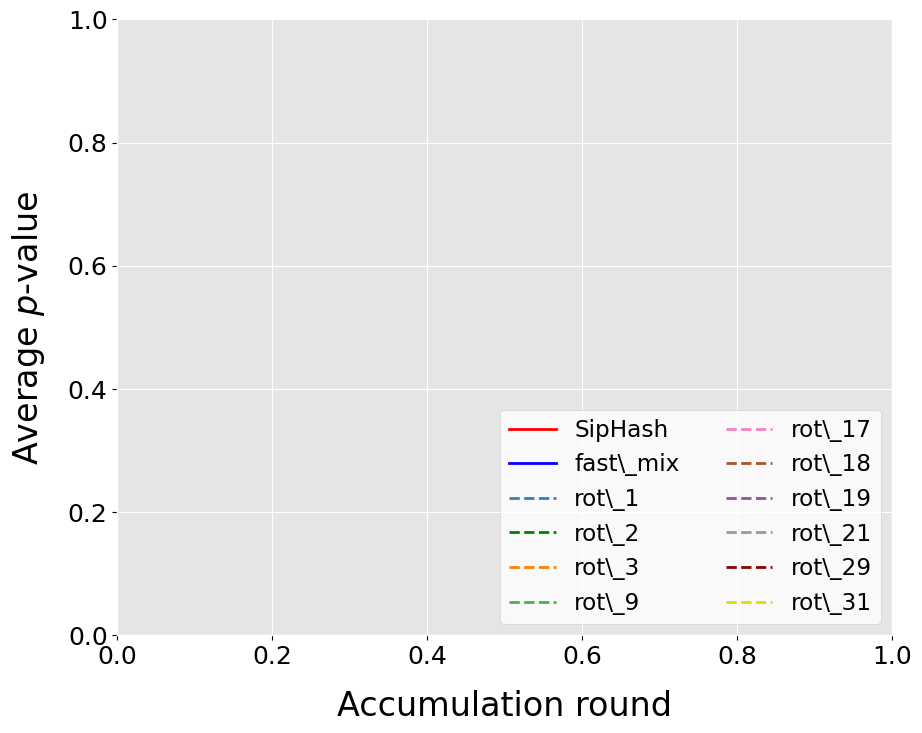

In [43]:
data_grouped = data_average.groupby(['function'])

CB_cycle = ['red', 'blue','#377eb8',

            'green' ,'#ff7f00', '#4daf4a',
            '#f781bf', '#a65628', '#984ea3',
            '#999999', 'darkred', '#dede00']

legend = ['SipHash', 'fast\_mix', 'rot\_1',

          'rot\_2', 'rot\_3', 'rot\_9',

          'rot\_17', 'rot\_18', 'rot\_19',

          'rot\_21', 'rot\_29', 'rot\_31']
lines = {
    'siphash': (CB_cycle[0], 2, '-'),
    'fast_mix': (CB_cycle[1], 2, '-'),
    'rot1': (CB_cycle[2], 1, '--'),
    'rot2': (CB_cycle[3], 1, '--'),
    'rot3': (CB_cycle[4], 1, '--'),
    'rot9': (CB_cycle[5], 1, '--'),
    'rot17': (CB_cycle[6], 1, '--'),
    'rot18': (CB_cycle[7], 1, '--'),
    'rot19': (CB_cycle[8], 1, '--'),
    'rot21': (CB_cycle[9], 1, '--'),
    'rot29': (CB_cycle[10], 1, '--'),
    'rot31': (CB_cycle[11], 1, '--')
}

plt.figure()
for name, group in data_grouped:
    if name in lines:
        plt.plot(group['round'], group['score'], marker='o', linestyle=lines[name][2], ms=4,

                 color=lines[name][0], zorder=lines[name][1])

legend_lines = []
for x in CB_cycle[:2]:

    legend_lines.append(Line2D([0], [0], color=x, lw=2, linestyle='-'))
for x in CB_cycle[2:]:

    legend_lines.append(Line2D([0], [0], color=x, lw=2, linestyle='--'))

plt.xlabel(r"Accumulation round")
plt.ylabel(r"Average $p$-value")
plt.legend(legend_lines, legend, loc='lower right', fontsize='small', facecolor='white', ncol=2)
plt.show()

In [33]:
test = data_average[data_average['round'] == 4]
test.sort_values('score').head(5)

,function,round,score
124,rot2,4,0.323926
14,rot1,4,0.331570
234,rot3,4,0.375626
254,rot31,4,0.401407
244,rot30,4,0.422906
164,rot23,4,0.520176
154,rot22,4,0.522942
264,rot4,4,0.526429
34,rot11,4,0.527442
94,rot17,4,0.527874


In [34]:
filtered_data = data_average[data_average['round'] > 2]
average_per_function = filtered_data.groupby('function')['score'].mean()
sorted_functions = average_per_function.sort_values()
# sorted_functions